<!-- ![FOTO](./img/logo.jpeg)  -->
# ***Deep Vision para tareas de clasificación***
## ***By Noelia Otazo Rojo***

### Objetivos
**Evaluar y comparar** estrategias para la **clasificación de imágenes**, la solución deberá estar basada en el **aprendizaje profundo (Redes Neuronales Convolucionales CNNs)**.

### Contenidos
1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos
4.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución
5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo.

### Fuente de datos
Enlace al dataset que voy a utilizar para llevar a cabo el siguiente proyecto:
[Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/data)



## 0. Preparación del proyecto.
En esta sección añadimeros las sentencias de instalación y las importaciones de las librerías necesarias para el desarrollo del proyecto.

In [2]:
#!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 667.8 kB/s eta 0:00:58
    --------------------------------------- 1.0/38.6 MB 10.1 MB/s eta 0:00:04
   -- ------------------------------------- 2.7/38.6 MB 19.2 MB/s eta 0:00:02
   ----- ---------------------------------- 5.2/38.6 MB 27.9 MB/s eta 0:00:02
   -------- ------------------------------- 8.2/38.6 MB 37.3 MB/s eta 0:00:01
   ----------- ---------------------------- 11.5/38.6 MB 59.5 MB/s eta 0:00:01
   --------------- ------------------------ 14.9/38.6 MB 65.2 MB/s eta 0:00:01
   ------------------ --------------------- 17.8/38.6 MB 65.2 MB/s eta 0:00:01
   --------

In [2]:
# Numpy
import numpy as np
from numpy.random import seed

# OpenCV to process images
import cv2

# Necesario para la tranformación de las imagenes de tif a png
import pathlib
from PIL import Image

# Directory indexes
import os
from os import listdir

import shutil
import random
from pathlib import Path
from pprint import pprint
from collections import defaultdict

# Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Pandas
import pandas as pd

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormaliz
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Ploteado del esquema gráfico del modelo
# from keras.utils.vis_utils import plot_model

## 1. Conjunto de datos.
En esta sección cargaremos el contenido del dataset para su posterior uso.

### 1.1 Carga del conjunto de datos.
De este modo tendremos ya almacenado en variables las ubicaciones de los ficheros de labels así como la ruta a la carpeta que contiene las imágenes.

In [25]:
# Data
test_data_path = 'histopathologic-cancer-detection/test'
train_data_path = 'histopathologic-cancer-detection/train'
train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
validation_labels = pd.read_csv('histopathologic-cancer-detection/validation_labels.csv')

# Obtiene los nombres de clase únicos como una lista
class_names = train_labels['label'].unique().tolist()

# Asegúrate de que los nombres de clase sean strings si es necesario
class_names = [str(name) for name in class_names]
print(train_labels.head())
print(validation_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0


###  1.2 Distribución train / test 
A continuación generaremos un gráfico para comprobar la distribución del contenido de train/test, ya que venía ya distribuído desde Kaggle, por lo que no será necesrio hacer un nuevo split de los datos.

La carpeta train tiene 220025 elementos con proporción 0.79
La carpeta test tiene 57458 elementos con proporción 0.21


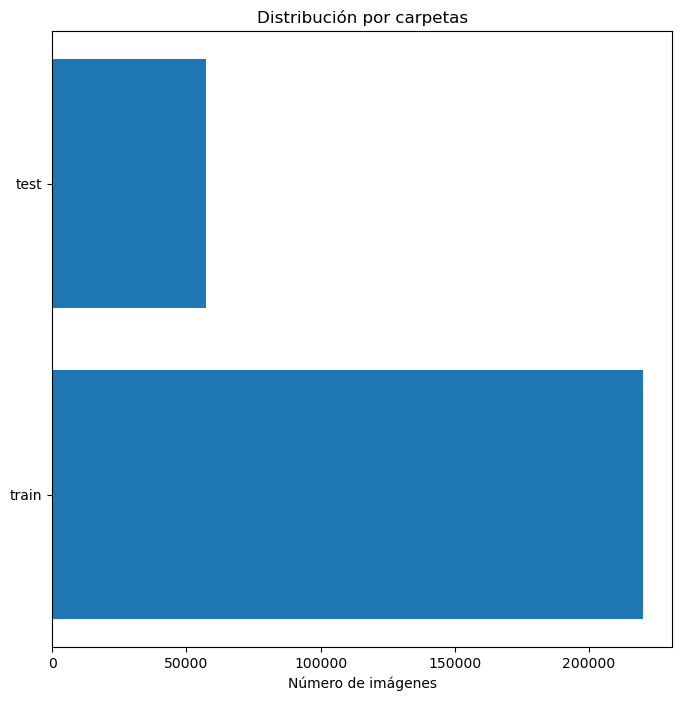

In [8]:
# Crea un Path object para el directorio de entrenamiento
paths_train_dataset = list(Path(train_data_path).rglob('*.tif'))
paths_test_dataset = list(Path(test_data_path).rglob('*.tif'))

# Combinamos ambos paths para conseguir el conteo total
paths_dataset = paths_train_dataset + paths_test_dataset

dict_dataset = defaultdict(list)

# Agrupa las imágenes por su carpeta (train o test)
for p in paths_dataset:
    dict_dataset[p.parent.name].append(str(p))

# Imprime la cantidad y la proporción de imágenes por carpeta
for k in dict_dataset.keys():
    print(f'La carpeta {k} tiene {len(dict_dataset[k])} elementos con proporción {len(dict_dataset[k])/len(paths_dataset):.2f}')

# Configura los parámetros de la figura para matplotlib
plt.rcParams["figure.figsize"] = (8, 8)

# Crea el gráfico de barras horizontal
plt.barh(y=list(dict_dataset.keys()), width=[len(dict_dataset[k]) for k in dict_dataset.keys()])
plt.title('Distribución por carpetas')
plt.xlabel('Número de imágenes')
plt.show()

La misma comprobación pero en un gráfico de sectores.

Los índices por clase son: 
{'test': 1, 'train': 0}


La distribución de los datos por clase es:
{'test': 0.20706854113585338, 'train': 0.7929314588641466}


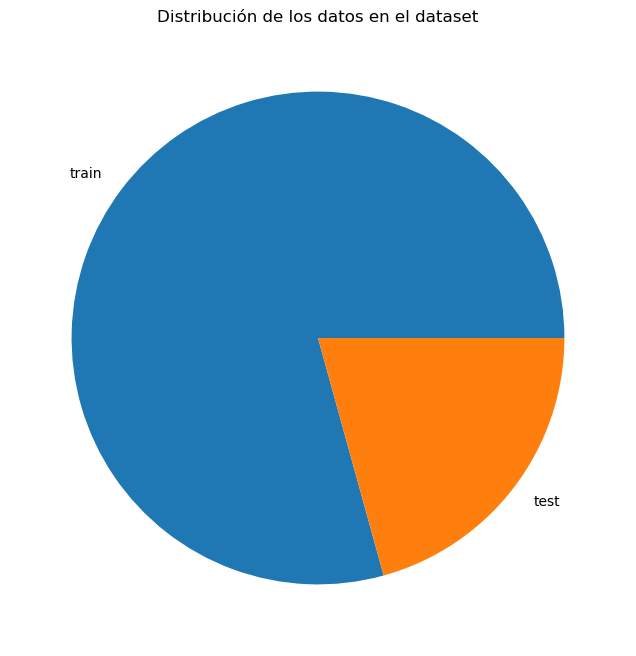

In [10]:
names_to_index = {k: i for i, k in enumerate(dict_dataset.keys())}
names_proportion = {k: len(dict_dataset[k])/len(paths_dataset) for k in dict_dataset.keys()}
print('Los índices por clase son: ')
pprint(names_to_index)
print('\n')
print('La distribución de los datos por clase es:')
pprint(names_proportion)

plt.pie(names_proportion.values(), labels=names_proportion.keys())
plt.title('Distribución de los datos en el dataset')
plt.show()

### 1.3 Visualización de los datos
Comprobamos que los datos son accesibles y que los podemos mostrar.

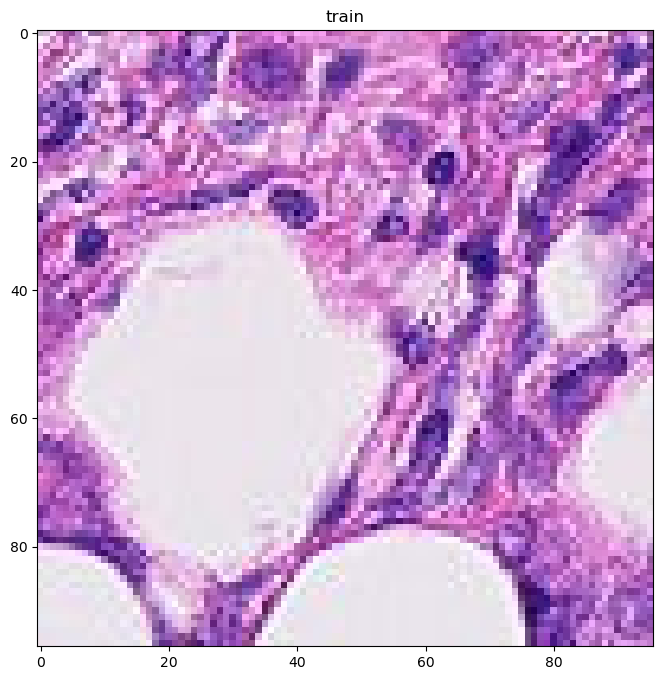

In [9]:
sample_path = random.choice(paths_dataset)

plt.imshow(cv2.imread(str(sample_path))[..., ::-1])
plt.title(sample_path.parent.name)
plt.show()

### 1.4 Formateo de las imágenes
Dado que las imágenes se encuentran en un formato .tif y para poder procesarlas necesitaremos un formato que esté aceptado por Tensorflow, las transformaremos a imágenes .png

In [16]:
# Define la ruta de origen y destino
src_path = pathlib.Path('histopathologic-cancer-detection/train')
def convert_image(src_path):
    dest_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

    # Crea el directorio de destino si no existe
    dest_path.mkdir(parents=True, exist_ok=True)

    # Convierte cada archivo .tif a .png
    for tif_image_path in src_path.glob('*.tif'):
        # Cargar la imagen .tif
        image = Image.open(tif_image_path)
        # Definir el nombre de archivo de destino con la extensión .png
        dest_image_path = dest_path / (tif_image_path.stem + '.png')
        # Guardar la imagen en formato .png
        image.save(dest_image_path, 'PNG')

# Ejecutar solo una vez
#convert_image(src_path=src_path)

Haremos lo mismo para test.

In [1]:
# Define la ruta de origen y destino
test_path = pathlib.Path('histopathologic-cancer-detection/test')

def convert_image_test(src_path):
    dest_path = pathlib.Path('histopathologic-cancer-detection/test_converted')

    # Crea el directorio de destino si no existe
    dest_path.mkdir(parents=True, exist_ok=True)

    # Convierte cada archivo .tif a .png
    for tif_image_path in src_path.glob('*.tif'):
        # Cargar la imagen .tif
        image = Image.open(tif_image_path)
        # Definir el nombre de archivo de destino con la extensión .png
        dest_image_path = dest_path / (tif_image_path.stem + '.png')
        # Guardar la imagen en formato .png
        image.save(dest_image_path, 'PNG')

# Ejecutar solo una vez
convert_image(src_path=src_path)

NameError: name 'pathlib' is not defined

Comprobamos si existen imágenes en el nuevo directorio de train.

In [17]:
# TRAIN
train_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(train_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {train_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {train_path}.")

# Crea un dataset a partir de los archivos de imagen
train_dataset = tf.data.Dataset.list_files(str(train_path/'*.png'), shuffle=True)

print(train_dataset)


Se encontraron 44586 imágenes en histopathologic-cancer-detection\train_converted.
<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


Comprobamos si existen imágenes en el nuevo directorio de test.

In [20]:
# TEST
test_path = pathlib.Path('histopathologic-cancer-detection/test_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(test_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {test_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {test_path}.")

# Crea un dataset a partir de los archivos de imagen
test_dataset = tf.data.Dataset.list_files(str(test_path/'*.png'), shuffle=True)

print(test_dataset)

Se encontraron 101463 imágenes en histopathologic-cancer-detection\test_converted.
<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


## Establecemos los parámetros
Estos parámetros serán los que posteriormente utilizaremos para el entrenamiento del modelo.

In [4]:
# Params 
# Train 
batch_size = 8
monitor = 'val_loss'
learning_rate = 1e-4
epochs = 50
early_stopping_patience = 4
train_backbone = True
version = 0
plateau_factor = 0.5
plateau_patience = 2

# Model 
input_shape = (224, 224, 3)
model_name = 'NOR-HISTOPATHOLOGIC-CANCER-DETECTION'

### 1.5 Dataframe
Dataframe hechos para train y test.

In [21]:
# Directorio de las imágenes
train_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(train_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {train_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {train_path}.")

# Cargar el archivo CSV
csv_path = 'histopathologic-cancer-detection/train_labels.csv'
labels_df = pd.read_csv(csv_path)

def get_label(file_path):
    file_name = tf.strings.split(file_path, os.path.sep)[-1]
    img_id = tf.strings.regex_replace(file_name, '.png', '')
    
    def get_label_py(img_id):
        img_id_str = img_id.numpy().decode('utf-8')
        label = labels_df.loc[labels_df['id'] == img_id_str, 'label'].values[0]
        return label

    label = tf.py_function(get_label_py, [img_id], Tout=tf.int32)
    return label

def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img /= 255.0
    label = get_label(file_path)
    return img, label

# Crear un dataset a partir de los archivos de imagen
train_dataset = tf.data.Dataset.list_files(str(train_path/'*.png'), shuffle=True)
train_dataset_labeled = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

# Visualizar el tipo de elementos en el conjunto de datos
for img, label in train_dataset_labeled.take(5):
    print("Imagen shape:", img.shape)
    print("Etiqueta:", label)


Se encontraron 44586 imágenes en histopathologic-cancer-detection\train_converted.


d:\anaconda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Imagen shape: (32, 256, 256, 3)
Etiqueta: tf.Tensor([0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0], shape=(32,), dtype=int32)
Imagen shape: (32, 256, 256, 3)
Etiqueta: tf.Tensor([1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0], shape=(32,), dtype=int32)
Imagen shape: (32, 256, 256, 3)
Etiqueta: tf.Tensor([1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1], shape=(32,), dtype=int32)
Imagen shape: (32, 256, 256, 3)
Etiqueta: tf.Tensor([0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
Imagen shape: (32, 256, 256, 3)
Etiqueta: tf.Tensor([0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0], shape=(32,), dtype=int32)


In [44]:

# Directorio de las imágenes de prueba
test_path = pathlib.Path('histopathologic-cancer-detection/test_converted')

# Cargar el archivo CSV con las etiquetas
labels_df = pd.read_csv('histopathologic-cancer-detection/sample_submission.csv')
labels_df.set_index('id', inplace=True)  # Usa 'id' como índice

# Función para cargar la imagen y obtener su etiqueta
def load_image_and_label(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img /= 255.0

    file_name = tf.strings.regex_replace(tf.strings.split(file_path, os.path.sep)[-1], '.png', '')
    
    def get_label(file_name):
        try:
            return labels_df.loc[file_name.numpy().decode()]['label']
        except KeyError:
            print("KeyError con el archivo:", file_name.numpy().decode())
            return -1  # Retornar un valor inválido o manejar de otro modo

    label = tf.py_function(func=get_label, inp=[file_name], Tout=tf.int32)
    
    return img, label

# Crear un dataset a partir de los archivos de imagen
test_dataset = tf.data.Dataset.list_files(str(test_path/'*.png'), shuffle=False)
test_dataset_labeled = test_dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

# Verificar el dataset
for img, label in test_dataset_labeled.take(1):
    print("Imagen shape:", img.shape)
    print("Etiqueta shape:", label.shape)


d:\anaconda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


KeyError con el archivo: 00016a638ed77529609ac61479dc7ee99a6f3711
KeyError con el archivo: 0000d563d5cfafc4e68acb7c9829258a298d9b6a
KeyError con el archivo: 00027298de60883932506d5c46be978d71a2da68
KeyError con el archivo: 0003bc63342dd32164456c537a14d7906e18eb69
KeyError con el archivo: 000418cc01330ea35ad8749f397a6624133405aa
KeyError con el archivo: 0004d129ba4596aa6bb2730dc453135fb40528db
KeyError con el archivo: 00088e05e659baddedf32388e31bfc1d7c18136e
KeyError con el archivo: 0006ed0cc8fa6edb4d2a74094cf2d26c85a1a33c
KeyError con el archivo: 0003378267bd3d9964d701ff9e52ddce1b027e46
KeyError con el archivo: 000b666f7b5f03e81937cb12b3a1c8c279b08292
KeyError con el archivo: 000aa5d8f68dc1f45ebba53b8f159aae80e06072
KeyError con el archivo: 0011d5555ca4a700e585f4a25fb090e13e700d8c
KeyError con el archivo: 00125e874ab586b90feb258775c24c262f5cb42d
KeyError con el archivo: 0013e23f3006d8ee4034b219fdb5e4132fcff393
KeyError con el archivo: 0013e7678b7f1fd89c7e3ba36c24b690618d28f1
KeyError c

Lo siguiente será definir una secuencia de capas de aumento de datos. Mediante el uso de la librería keras generaremos una transformación aleatoria de las imágenes de manera que mejoremos la generalización del modelo.

In [21]:
data_augmentation = keras.Sequential(
[
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation((-1, 1), fill_mode='reflect', interpolation='nearest'),
    keras.layers.experimental.preprocessing.RandomZoom(width_factor=(0, 0.2), height_factor=(0, 0.2), interpolation='nearest'),
]
)

A continuación visualizaremos algunos datos con la finalidad de verificar como se ven las imágenes del conjunto de datos y si las transformaciones están funcionando como se esperaba.

Images shape: (32, 256, 256, 3)
Labels shape: (32,)


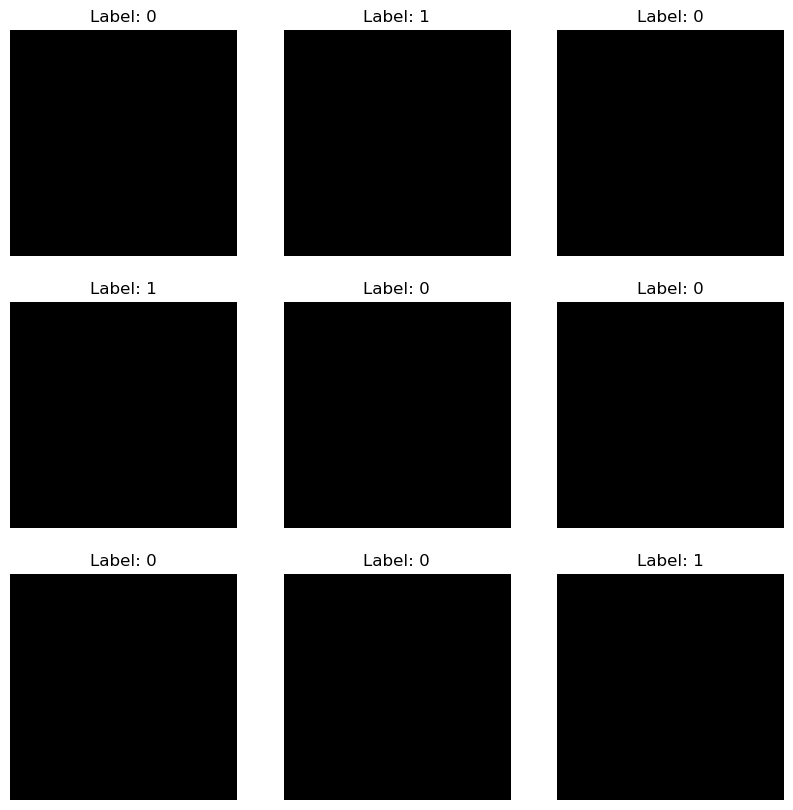

In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Configuración ansiosa activada para depuración
tf.config.run_functions_eagerly(True)

plt.figure(figsize=(10, 10))

# Toma un lote del dataset
for images, labels in train_dataset_labeled.take(1):
    print("Images shape:", images.shape)  # Imprime la forma del tensor de imágenes
    print("Labels shape:", labels.shape)  # Imprime la forma del tensor de etiquetas

    num_images = images.shape[0]
    num_subplots = min(num_images, 9)  # Limita a 9 imágenes o menos

    for i in range(num_subplots):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.cast(images[i], tf.uint8)  # Convierte para visualización
        plt.imshow(img)
        
        if labels.ndim > 0:  # Verifica si las etiquetas tienen más de una dimensión
            label = labels[i].numpy()  # Solo intenta esto si las etiquetas no son escalares
        else:
            label = labels.numpy()  # Manejo en caso de que label sea un tensor escalar
        
        plt.title(f"Label: {label}")
        plt.axis("off")

plt.show()


CARGA CORRECTA DE LAS IMAGENES

In [4]:
# Rutas a los directorios y archivos
train_dir = 'histopathologic-cancer-detection/train_converted'
train_labels_csv = 'histopathologic-cancer-detection/train_labels.csv'

# Cargar las etiquetas
labels_df = pd.read_csv(train_labels_csv)
labels_df['id'] = labels_df['id'].apply(lambda x: x + '.png')  # Asegurarte de que los IDs tienen la extensión .png

# Crear un generador de imágenes que también realiza la normalización de las mismas
datagen = ImageDataGenerator(rescale=1./255)

# Este generador carga las imágenes directamente del disco en lotes, por lo que no es necesario cargar todas las imágenes en la memoria a la vez
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_dir,
    x_col='id',  # Nombre del archivo de la imagen
    y_col='label',  # Columna con las etiquetas
    class_mode='raw',  # Tipo de problema de clasificación (binary para 0 o 1)
    target_size=(256, 256),  # Tamaño al que se redimensionarán las imágenes
    batch_size=32,  # Tamaño de los lotes de datos
    shuffle=True  # Mezclar los datos de manera aleatoria
)


Found 44586 validated image filenames.


d:\anaconda\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 175439 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [8]:
# Rutas a los directorios y archivos de validación
validation_dir = 'histopathologic-cancer-detection/test_converted'
validation_labels_csv = 'histopathologic-cancer-detection/validation_labels.csv'

# Cargar las etiquetas de validación
validation_labels_df = pd.read_csv(validation_labels_csv)
validation_labels_df['id'] = validation_labels_df['id'].apply(lambda x: x + '.png')  # Asegurarte de que los IDs tienen la extensión .png

# Crear un generador de imágenes que también realiza la normalización de las mismas para validación
datagen_validation = ImageDataGenerator(rescale=1./255)

# Este generador carga las imágenes de validación directamente del disco en lotes
validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_labels_df,
    directory=validation_dir,
    x_col='id',  # Nombre del archivo de la imagen
    y_col='label',  # Columna con las etiquetas
    class_mode='raw',  # Uso de 'raw' para etiquetas numéricas
    target_size=(256, 256),  # Tamaño al que se redimensionarán las imágenes
    batch_size=32,  # Tamaño de los lotes de datos
    shuffle=True  # Mezclar los datos de manera aleatoria
)

Found 57458 validated image filenames.


MODELO Y ENTRENAMIENTO

In [33]:
def get_model(model_name: str, input_shape: tuple, train_backbone: bool, num_classes: int):
    inputs = keras.Input(shape=input_shape)
    data_augmentation = keras.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        keras.layers.experimental.preprocessing.RandomRotation((-1, 1), fill_mode='reflect', interpolation='nearest'),
        keras.layers.experimental.preprocessing.RandomZoom(width_factor=(0, 0.2), height_factor=(0, 0.2), interpolation='nearest'),
    ])
    x = data_augmentation(inputs)
    
    # Define un diccionario para facilitar la adición de nuevos modelos
    base_models = {
        'mobilenetv2': keras.applications.MobileNetV2,
        'resnet50': keras.applications.ResNet50V2,
        # Agrega nuevos modelos aquí como sigue:
        # 'nombre_modelo': keras.applications.NombreModeloKeras
    }

    # Preprocesamiento y selección del modelo base según el nombre del modelo
    if model_name in base_models:
        preprocess_input = getattr(keras.applications, model_name).preprocess_input
        x = preprocess_input(x)
        base_model = base_models[model_name](
            include_top=False,
            weights="imagenet",
            input_tensor=x,
            input_shape=input_shape,
        )
    else:
        raise ValueError(f"Modelo '{model_name}' no reconocido. Elija entre: {list(base_models.keys())}")
    
    base_model.trainable = train_backbone
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(x.shape[-1] // 2, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x) 
    x = keras.layers.Dense(x.shape[-1] // 2, activation='relu')(x) 
    predictions = keras.layers.Dense(1, activation='sigmoid')(x) 
    model = keras.Model(inputs=inputs, outputs=predictions)

    return model

# Parámetros de configuración
model_name = 'resnet50'  # Cambia esto según el modelo deseado
input_shape = (224, 224, 3)  # Asegúrate de que la forma de entrada es correcta para el modelo seleccionado
train_backbone = False  # Decide si entrenar o no las capas base del modelo
num_classes = 12  # Número de clases en tu dataset

# Crea el modelo
model = get_model(model_name, input_shape, train_backbone, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 tf.__operators__.getitem_1  (None, 224, 224, 3)          0         ['sequential_2[0][0]']        
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)          0         ['tf.__operators__.getit

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(f'weights/{model_name}/version_{version}', save_best_only=True, monitor=monitor),
    keras.callbacks.EarlyStopping(monitor=monitor, patience=early_stopping_patience, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=plateau_factor, patience=plateau_patience, mode='auto'),
    keras.callbacks.TensorBoard(log_dir=f'weights/{model_name}/version_{version}')
]

In [35]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.BinaryAccuracy()  # Cambiado de CategoricalAccuracy a BinaryAccuracy
    ]
)

# Entrenamos el modelo
H = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=callbacks
)



Epoch 1/50

1394/1394 [==============================] - ETA: 0s - loss: 39.8199 - precision_5: 0.4018 - recall_5: 0.4022 - binary_accuracy: 0.5166INFO:tensorflow:Assets written to: weights/resnet50\version_0\assets


INFO:tensorflow:Assets written to: weights/resnet50\version_0\assets


1394/1394 [==============================] - 6226s 4s/step - loss: 39.8199 - precision_5: 0.4018 - recall_5: 0.4022 - binary_accuracy: 0.5166 - val_loss: 0.0182 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_binary_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/50
1394/1394 [==============================] - ETA: 0s - loss: 7.8170 - precision_5: 0.4065 - recall_5: 0.4063 - binary_accuracy: 0.5205INFO:tensorflow:Assets written to: weights/resnet50\version_0\assets


INFO:tensorflow:Assets written to: weights/resnet50\version_0\assets


1394/1394 [==============================] - 6192s 4s/step - loss: 7.8170 - precision_5: 0.4065 - recall_5: 0.4063 - binary_accuracy: 0.5205 - val_loss: 3.1920e-04 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_binary_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/50
1394/1394 [==============================] - 6196s 4s/step - loss: 3.8613 - precision_5: 0.4055 - recall_5: 0.4036 - binary_accuracy: 0.5200 - val_loss: 0.8533 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/50
1394/1394 [==============================] - 6176s 4s/step - loss: 2.3774 - precision_5: 0.4071 - recall_5: 0.4007 - binary_accuracy: 0.5221 - val_loss: 1.6142 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 5/50
1394/1394 [==============================] - 6137s 4s/step - loss: 1.4763 - precision_5: 0.4031 - recall_5: 0.3875 - binary_accuracy: 0.5207 - val_loss: 0.8745 - v

In [6]:
# Gráficas losses
epochs_trained = len(H.history['loss'])
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs_trained), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, epochs_trained), H.history['val_loss'], label='val_loss')

plt.title(f'Training and Val Loss {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'weights/{model_name}/version_{version}/losses.png')
plt.show()


NameError: name 'H' is not defined

In [5]:
# Gráficas precision recall
plt.style.use('ggplot')
plt.figure()

plt.plot(np.arange(0, epochs_trained), H.history['precision'], label='train_precision')
plt.plot(np.arange(0, epochs_trained), H.history['recall'], label='train_recall')
plt.plot(np.arange(0, epochs_trained), H.history['categorical_accuracy'], label='train_categorical_accuracy')

plt.plot(np.arange(0, epochs_trained), H.history['val_precision'], label='val_precision')
plt.plot(np.arange(0, epochs_trained), H.history['val_recall'], label='val_recall')
plt.plot(np.arange(0, epochs_trained), H.history['val_categorical_accuracy'], label='val_categorical_accuracy')

plt.title(f'Training and val Accuracy/Precision/Recall {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Precision/Recall')
plt.legend()
plt.savefig(f'weights/{model_name}/version_{version}/metrics.png')
plt.show()

NameError: name 'epochs_trained' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
# TODO mejorar este código horrible  
del model
print('Loading model from checkpoint ...')
model = keras.models.load_model(f'weights/{model_name}/version_{version}')
print('Model loaded!')

# Inferencia, preparada para inferir en forma de batch
preds = []
targets = []
for imgs, labels in tqdm(test_dataset):
    preds += [int(pred) for pred in tf.argmax(model.predict(imgs), axis=1)]
    targets += [int(label) for label in tf.argmax(labels, axis=1)]

# Métricas de clasificación 
print(classification_report(targets, preds, target_names=class_names))